# ARIMA (autoregressive integrated moving average) Model

## Import, handle missing values, create a clean dataframe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import floor, sqrt

ic = pd.read_excel("D:\DS\Mine\Corona\I21-11.xlsx", index_col=0, parse_dates=[0]) # Iran Corona for 2021-11-..
ic['total_vaccinations_f'] = ic['total_vaccinations'].interpolate(method='linear')
ic['stringency_index_f'] = ic['stringency_index'].fillna(method="ffill")
icf = ic.loc[ : , ['datei', 'total_cases', 'new_cases', 'new_cases_smoothed',
                   'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_vaccinations_f', 'stringency_index_f']]

icf.loc[:, "datei"] = icf["datei"].apply(lambda x: x - 43880)
pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('display.max_rows', 2000)
icf

,datei,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_vaccinations_f,stringency_index_f
date,,,,,,,,,
2020-02-19,0,2,2,NaN,2,2,NaN,0.00,0.00
2020-02-20,1,5,3,NaN,2,0,NaN,0.00,2.78
2020-02-21,2,18,13,NaN,4,2,NaN,0.00,2.78
2020-02-22,3,28,10,NaN,5,1,NaN,0.00,11.11
2020-02-23,4,43,15,NaN,8,3,NaN,0.00,11.11
...,...,...,...,...,...,...,...,...,...
2021-11-24,644,6092822,4813,"4,989.86",129280,103,107.00,"102,145,229.00",69.91
2021-11-25,645,6097672,4850,"4,842.43",129376,96,106.00,"102,145,229.00",69.91
2021-11-26,646,6102056,4384,"4,642.43",129462,86,104.00,"102,145,229.00",69.91


## Checking stationarity of the data 'new_cases'

<AxesSubplot:xlabel='date'>

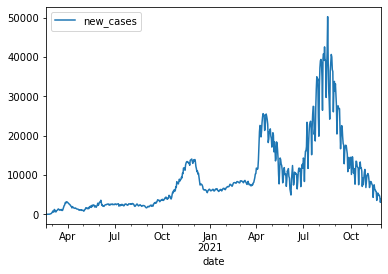

In [2]:
icf.plot(y='new_cases')

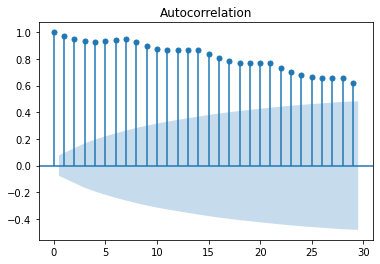

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
icn = icf.loc[:,'new_cases']
plot_acf(icn);

In [4]:
icd = icn.diff(periods=1)
icd = icd[1:]
icd

date
2020-02-20        1.00
2020-02-21       10.00
2020-02-22       -3.00
2020-02-23        5.00
2020-02-24        3.00
                ...   
2021-11-24     -331.00
2021-11-25       37.00
2021-11-26     -466.00
2021-11-27   -1,339.00
2021-11-28      736.00
Name: new_cases, Length: 648, dtype: float64

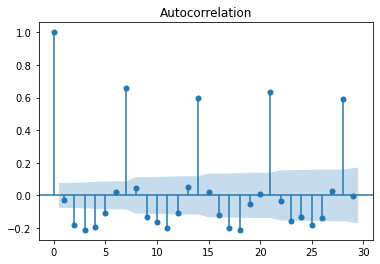

In [5]:
plot_acf(icd);

<AxesSubplot:xlabel='date'>

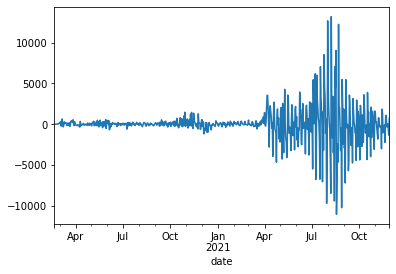

In [6]:
icd.plot()

In [7]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(icd)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.713992
p-value: 0.003921


**>> Using d = 1 (1 time differencing) the data becomes stationary (p-value < 0.05).**

## Defining constants, spliting train and test for ARIMA

In [21]:
length = icn.shape[0]                #number of records
train_len = floor(length * 0.90)     #90% of records are going to be used for training
print('Out of', length, 'samples,', train_len, 'samples were devoted to training section and the rest (i.e.',
      length - train_len, 'samples) to test section.')
prl = 10                                    #prediction lendth: number of days to predict

xd = icn.values
xr = xd[:train_len]
xs = xd[train_len:train_len+prl]
xsp = []

Out of 649 samples, 584 samples were devoted to training section and the rest (i.e. 65 samples) to test section.


### Single set of parameters for an initial model

In [22]:
# Running ARIMA using p=10, d=1 and q=1
from statsmodels.tsa.arima.model import ARIMA
print('On', icf.index[train_len].strftime('%Y-%m-%d'), 'a prediction of', prl, 'days is as follows:')
arim = ARIMA(xr, order=(10, 1, 1))
arim_fit = arim.fit()
# print(arim_fit.aic)
xsp = arim_fit.forecast(steps=prl)
print('Using (p, d, q) = (10, 1, 1):')
for i in range (prl):
    print('Actual =', xs[i], '- predicted =', "{:2.1f}".format(xsp[i]))

On 2021-09-25 a prediction of 10 days is as follows:
Using (p, d, q) = (10, 1, 1):
Actual = 10843 - predicted = 12162.4
Actual = 13792 - predicted = 14114.0
Actual = 14470 - predicted = 15531.0
Actual = 11701 - predicted = 15861.7
Actual = 13271 - predicted = 15982.3
Actual = 14078 - predicted = 15001.9
Actual = 14525 - predicted = 14003.7
Actual = 10135 - predicted = 12051.2
Actual = 12428 - predicted = 13230.8
Actual = 14607 - predicted = 14419.0


In [23]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt, floor
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, xsp)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, xsp)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, xsp))))

MAE:  Mean Absolute Error =            1392.68
MAPE: Mean Absolute Percentage Error = 11.5%
RMSE: Root Mean Squared Error =        1819.62


## Search to find the best parameters for ARIMA

### Constants

In [24]:
interval = 30    #interval: is going to be used for predictions at every 'interval' records
startp = 200     #start position: to start forcasting after this point

### Parameters sets

In [25]:
import itertools #To ease the process of combining parameters.

#Parameter values:
# pv = [1, 2, 3, 7, 10, 12, 14]#, 15, 16, 20]#, 30]#, 60]
pv = range(1, 16)
dv = range(0, 3)
qv = range(0, 3)
pdq = list(itertools.product(pv, dv, qv))
print(len(pdq), 'set of parameters are going to be compared:')

135 set of parameters are going to be compared:


### Fitting models and RMSE comparison within the training section

In [26]:
import warnings
import itertools
import math
from statistics import mean, stdev
import time
warnings.filterwarnings('ignore')

lowest_rmse, best_cfg = float("inf"), None
cols = math.floor((train_len - startp - prl) / interval) #columns: is calculated to be used as the number of columns in this study
rmse = np.zeros([len(pdq), cols]) #root mean square error 
print('Search to find best parameters using', len(pdq), 'parameters sets in', cols, 'points of dataset:')
np.set_printoptions(precision=0)
fit_model = [None]*len(pdq)
errors = 0
start_time = time.time()

for i in range(len(pdq)):
    print('\nParameters set', i, ': (p, d, q) =', pdq[i])
    j = 0
    while j < cols:
        try:
            model = ARIMA(xr[:startp+j*interval], order=pdq[i])
            fit_model[i] = model.fit()
            xs = xr[startp+(j*interval):startp+(j*interval)+prl]
            xsp = fit_model[i].predict(start=startp+(j*interval), end=startp+(j*interval)+prl-1)
            print('On', startp + j*interval, 'Actuals =', xs, 'Predictions =', xsp)
            rmse[i][j] = sqrt(mean_squared_error(xs, xsp))
        except Exception as e:
            errors += 1
            print(e)
            j += 1
            continue
        j += 1
       
    if mean(rmse[i]) < lowest_rmse:
        lowest_rmse, best_cfg = mean(rmse[i]), pdq[i]
    print("  > RMSE:","{:2.2f}".format(mean(rmse[i])))

delta = time.time() - start_time
delta_min, delta_sec = divmod(delta, 60)
print('\n\nThe code was completed in {:.0f} minutes and'.format(delta_min), '{:.2f} seconds.'.format(delta_sec))
print('Fitting errors:', errors)
print('********************************* Best Score *********************************')
print('Lowest RMSE', "{:2.2f}".format(lowest_rmse), 'was acheived using parameters set (p, d, q) =', best_cfg)
# print(rmse)


Search to find best parameters using 135 parameters sets in 12 points of dataset:

Parameters set 0 : (p, d, q) = (1, 0, 0)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1895. 1896. 1896. 1897. 1898. 1898. 1899. 1900. 1900. 1901.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3873. 3845. 3817. 3789. 3762. 3736. 3710. 3684. 3658. 3633.]
On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [8437. 8423. 8408. 8393. 8379. 8364. 8350. 8335. 8321. 8306.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13330. 13319. 13308. 13297. 13285. 13274. 13263. 13252. 13241. 13230.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [5950. 5940. 5930. 5920. 5910. 5900. 5890. 5881. 5871. 5861.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6808. 6796. 6784. 6772. 6761. 6749. 6

On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13487. 13374. 13462. 13394. 13446. 13406. 13437. 13413. 13432. 13417.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [5955. 5959. 5956. 5958. 5956. 5958. 5957. 5957. 5957. 5957.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6809. 6818. 6811. 6816. 6812. 6815. 6813. 6815. 6813. 6815.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8431. 8410. 8426. 8414. 8423. 8416. 8421. 8417. 8420. 8418.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11358. 11407. 11368. 11399. 11375. 11394. 11379. 11390. 11381. 11388.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21193. 21264. 21274. 21276. 21276. 21276. 21276. 21276. 21276. 21276.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  996

On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [20678. 20855. 20832. 20982. 20982. 21113. 21130. 21245. 21276. 21380.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [11947. 11903. 11944. 11966. 11992. 12017. 12042. 12068. 12093. 12118.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [13525. 13620. 13633. 13663. 13690. 13717. 13744. 13771. 13798. 13825.]
On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [32819. 32680. 32905. 32834. 33003. 32977. 33110. 33113. 33222. 33245.]
  > RMSE: 3032.45

Parameters set 9 : (p, d, q) = (2, 0, 0)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1897. 1897. 1898. 1899. 1899. 1900. 1900. 1901. 1902. 1902.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3867. 3842. 3817. 3792. 3768. 3744. 3720. 3697. 367

On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1897. 1907. 1897. 1906. 1899. 1904. 1900. 1903. 1900. 1903.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3893. 3900. 3902. 3903. 3903. 3903. 3903. 3903. 3903. 3903.]
On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [8532. 8447. 8495. 8463. 8483. 8471. 8479. 8474. 8477. 8475.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13483. 13311. 13425. 13337. 13402. 13353. 13390. 13362. 13383. 13367.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [5909. 5906. 5894. 5898. 5893. 5896. 5893. 5895. 5894. 5895.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6898. 6925. 6934. 6937. 6939. 6939. 6939. 6939. 6939. 6939.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8428. 8388. 8410

On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [5835. 5748. 5635. 5542. 5433. 5336. 5231. 5132. 5028. 4927.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6894. 6942. 6980. 7020. 7058. 7097. 7135. 7173. 7211. 7250.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8472. 8472. 8538. 8558. 8613. 8642. 8691. 8725. 8770. 8806.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11418. 11617. 11751. 11954. 12109. 12302. 12466. 12652. 12821. 13003.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21304. 21406. 21532. 21534. 21634. 21635. 21730. 21733. 21826. 21831.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [11294. 10781. 10724. 11143. 11735. 12243. 12593. 12854. 13117. 13424.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 1766

On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21688. 21568. 21101. 20784. 20734. 20823. 20912. 20944. 20933. 20911.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [11769. 11602. 11479. 11483. 11523. 11537. 11531. 11524. 11523. 11525.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [13330. 13024. 13149. 13302. 13337. 13293. 13258. 13258. 13272. 13278.]
On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [35796. 32964. 29813. 30034. 31439. 31931. 31490. 31101. 31141. 31330.]
  > RMSE: 3232.17

Parameters set 22 : (p, d, q) = (3, 1, 1)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1901. 1901. 1889. 1900. 1891. 1898. 1893. 1897. 1894. 1896.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3928. 3908. 3947. 3912. 3943. 3918. 3939. 3922. 39

On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [35893. 33136. 30017. 30287. 31766. 32329. 31943. 31603. 31701. 31955.]
  > RMSE: 3120.17

Parameters set 26 : (p, d, q) = (3, 2, 2)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1910. 1919. 1916. 1937. 1936. 1953. 1957. 1970. 1977. 1988.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3944. 3940. 3995. 3978. 4025. 4018. 4055. 4056. 4086. 4092.]
On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [ 8678.  8706.  8936.  9083.  9262.  9408.  9562.  9710.  9862. 10014.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13604. 13563. 13817. 13853. 13975. 14005. 14089. 14147. 14233. 14304.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [5992. 6091. 6163. 6187. 6169. 6142. 6128. 6133. 6148. 6164.]
On 350 Ac

On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [5919. 5918. 5901. 5899. 5892. 5894. 5891. 5892. 5891. 5891.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6895. 6904. 6915. 6922. 6928. 6930. 6931. 6931. 6932. 6931.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8436. 8406. 8430. 8413. 8423. 8415. 8421. 8417. 8420. 8418.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11217. 11270. 11250. 11266. 11241. 11249. 11241. 11246. 11242. 11244.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21676. 21648. 21161. 20775. 20655. 20728. 20843. 20909. 20915. 20889.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [11616. 11130. 11043. 11044. 11085. 11152. 11165. 11148. 11135. 11128.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 1766

On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21263. 20918. 19636. 18906. 19013. 19570. 20060. 20049. 19678. 19293.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [11130. 10293. 10334. 10442. 10617. 10748. 10647. 10519. 10459. 10450.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [13267. 13131. 13103. 13275. 13408. 13435. 13425. 13420. 13441. 13479.]
On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [36441. 36549. 34984. 31479. 32118. 34718. 36587. 37499. 37085. 36665.]
  > RMSE: 2623.11

Parameters set 35 : (p, d, q) = (4, 2, 2)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1910. 1919. 1915. 1936. 1935. 1952. 1956. 1969. 1975. 1987.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3947. 3940. 3994. 3975. 4024. 4014. 4053. 4053. 40

On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [5926. 5932. 5914. 5904. 5892. 5891. 5888. 5888. 5886. 5885.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6899. 6896. 6902. 6919. 6935. 6942. 6944. 6945. 6946. 6947.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8437. 8426. 8452. 8440. 8444. 8438. 8442. 8440. 8442. 8441.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11227. 11281. 11287. 11304. 11281. 11284. 11278. 11282. 11280. 11281.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21600. 21570. 20947. 20607. 20598. 20771. 20912. 20931. 20882. 20833.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [12229. 11583. 10793. 10782. 10809. 10804. 10990. 11190. 11175. 11097.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 1766

On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21699. 21192. 20379. 18987. 18851. 19733. 20852. 21295. 21089. 20282.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [12426. 10805.  9779. 10930. 11657. 11910. 12734. 12864. 11972. 11794.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [12802. 13423. 15165. 14952. 15636. 16538. 16598. 16196. 17050. 17719.]
On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [39045. 38895. 39977. 36935. 29677. 31528. 38450. 42023. 43848. 44328.]
  > RMSE: 2302.95

Parameters set 44 : (p, d, q) = (5, 2, 2)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1910. 1918. 1914. 1934. 1933. 1950. 1953. 1966. 1972. 1983.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3947. 3941. 3994. 3975. 4023. 4014. 4052. 4052. 40

On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [36130. 35686. 35805. 31703. 25898. 25500. 30343. 35399. 37214. 34823.]
  > RMSE: 3073.79

Parameters set 48 : (p, d, q) = (6, 1, 0)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1901. 1882. 1850. 1853. 1854. 1861. 1864. 1867. 1869. 1868.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3898. 3925. 3936. 3912. 3898. 3893. 3889. 3889. 3890. 3892.]
On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [8496. 8381. 8415. 8434. 8501. 8457. 8471. 8451. 8460. 8457.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13425. 13339. 13508. 13418. 13499. 13374. 13424. 13377. 13428. 13395.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [5960. 5999. 6024. 6004. 5954. 5929. 5921. 5929. 5933. 5929.]
On 350 Actuals = [6

On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [ 8750.  8824.  9037.  9178.  9424.  9582.  9769.  9928. 10103. 10267.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13448. 13289. 13496. 13472. 13609. 13551. 13571. 13510. 13530. 13518.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6093. 6212. 6330. 6373. 6325. 6230. 6213. 6265. 6341. 6407.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6943. 6965. 6967. 6890. 6947. 7099. 7253. 7350. 7405. 7423.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8388. 8313. 8444. 8602. 8673. 8682. 8655. 8638. 8640. 8722.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11701. 12291. 12773. 13320. 13963. 14145. 14315. 14622. 15080. 15520.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 1640

On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [7012. 7097. 7053. 6898. 6832. 6904. 7082. 7233. 7269. 7161.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8277. 8097. 8139. 8257. 8385. 8365. 8232. 8026. 7897. 7897.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11643. 12106. 12249. 12386. 12421. 12371. 12267. 12309. 12451. 12620.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [22301. 22050. 20905. 19111. 18504. 19559. 21505. 22641. 22212. 20515.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [13337. 13488. 11394. 11309. 12487. 12027. 11416. 12556. 12773. 11418.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [12101. 12480. 13790. 12514. 12042. 13704. 13609. 11963. 12684. 13854.]
On 530 Actuals = [37189 39019 39357 38674 34913 26

On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [11907. 11159.  9759. 10980. 12398. 12649. 13010. 13342. 12670. 12030.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [12083. 13311. 15940. 16057. 15860. 17243. 17313. 16324. 17285. 19278.]
On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [37940. 38993. 38792. 37178. 28850. 26712. 36978. 43441. 43652. 43078.]
  > RMSE: 2184.32

Parameters set 61 : (p, d, q) = (7, 2, 1)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1881. 1850. 1833. 1874. 1906. 1929. 1923. 1932. 1934. 1933.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3951. 3980. 4057. 3990. 3985. 4022. 4072. 4097. 4125. 4157.]
On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [9037. 8869. 8972. 8949. 9302. 9439. 9477. 9697. 9717. 9827.]

On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1890. 1859. 1846. 1873. 1886. 1895. 1880. 1894. 1880. 1885.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3935. 3878. 3943. 3777. 3795. 3736. 3763. 3704. 3694. 3661.]
On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [9125. 8587. 9023. 8560. 9193. 8816. 9174. 8987. 9061. 9019.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13216. 13004. 13196. 13161. 13207. 13164. 12952. 12914. 12731. 12826.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6132. 6059. 6283. 6138. 6218. 5975. 6087. 5923. 6052. 5943.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6913. 6872. 6848. 6693. 6764. 6791. 6903. 6882. 6899. 6810.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8343. 8228. 8327

On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6065. 6137. 6297. 6344. 6318. 6235. 6216. 6217. 6272. 6349.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6970. 6987. 7007. 6910. 6993. 7100. 7247. 7365. 7444. 7471.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8382. 8303. 8436. 8564. 8624. 8679. 8644. 8633. 8615. 8696.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11690. 12290. 12778. 13355. 14037. 14161. 14461. 14725. 15162. 15571.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21177. 21178. 19904. 19043. 18093. 19537. 21058. 21395. 20980. 19944.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [12003. 11113.  9573. 10914. 12166. 12439. 12943. 13267. 12477. 11790.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 1766

On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21358. 21326. 19696. 18573. 17356. 18969. 20470. 20937. 20200. 18490.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [11822. 10869.  9244. 10339. 11514. 11614. 11885. 12005. 11043. 10132.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [11712. 12497. 14583. 14421. 14000. 15179. 14835. 13402. 13735. 15015.]
On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [37600. 38456. 37785. 35760. 26805. 24378. 33797. 39434. 39835. 38753.]
  > RMSE: 2468.87

Parameters set 74 : (p, d, q) = (9, 0, 2)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1888. 1856. 1843. 1872. 1887. 1897. 1880. 1893. 1880. 1883.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3908. 3874. 3920. 3768. 3763. 3721. 3747. 3683. 36

On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [37497. 37339. 35565. 34581. 26749. 25185. 33921. 37643. 38088. 37744.]
  > RMSE: 2552.48

Parameters set 78 : (p, d, q) = (9, 2, 0)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1858. 1809. 1789. 1827. 1857. 1877. 1856. 1847. 1822. 1811.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [4018. 4076. 4205. 4159. 4224. 4297. 4414. 4513. 4600. 4689.]
On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [ 9258.  9089.  9440.  9253.  9727.  9866. 10087. 10387. 10410. 10741.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13251. 13041. 13156. 13083. 13293. 13253. 13032. 12989. 12775. 12813.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6073. 6179. 6371. 6379. 6341. 6238. 6212. 6225. 6330. 6421.]
On 350 Ac

On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [9150. 8642. 9026. 8486. 9130. 8753. 9120. 8884. 8986. 8860.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13333. 13031. 13233. 13151. 13325. 13190. 13059. 12988. 12799. 12895.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6171. 6133. 6357. 6218. 6289. 6021. 6138. 6009. 6163. 6067.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6914. 6860. 6841. 6672. 6726. 6755. 6892. 6863. 6875. 6768.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8346. 8224. 8312. 8397. 8422. 8396. 8296. 8232. 8136. 8163.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11609. 11911. 12261. 12524. 13055. 12885. 13064. 12883. 13190. 13119.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] P

On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6990. 7046. 7035. 6864. 6853. 6939. 7103. 7260. 7319. 7226.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8376. 8288. 8412. 8537. 8605. 8610. 8533. 8518. 8466. 8556.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11662. 12040. 12357. 12654. 13083. 12925. 13026. 12817. 13100. 13111.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21304. 21527. 20375. 19643. 18783. 20296. 21929. 22445. 22284. 21322.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [12522. 11941.  9399. 10059. 12399. 12512. 12274. 13175. 12776. 11117.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [11448. 12438. 14853. 14456. 14202. 15902. 15432. 13371. 14290. 16200.]
On 530 Actuals = [37189 39019 39357 38674 34913 26

On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21262. 21156. 19798. 18850. 17791. 19163. 20576. 20873. 20198. 18944.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [11868. 10915.  9178. 10288. 11474. 11521. 11872. 12065. 11066. 10099.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [11655. 12438. 14467. 14258. 13971. 15247. 14843. 13322. 13735. 14942.]
On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [37670. 38349. 37641. 35999. 27163. 24872. 34051. 39237. 39841. 39051.]
  > RMSE: 2463.01

Parameters set 91 : (p, d, q) = (11, 0, 1)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1901. 1884. 1897. 1946. 1965. 1955. 1909. 1912. 1903. 1919.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3976. 3884. 3955. 3788. 3782. 3749. 3824. 3768. 3

On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [38094. 38592. 37857. 36271. 27572. 25244. 34716. 40268. 40979. 40310.]
  > RMSE: 2576.49

Parameters set 95 : (p, d, q) = (11, 1, 2)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1889. 1885. 1874. 1893. 1902. 1890. 1856. 1885. 1892. 1882.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [4005. 3932. 4026. 3893. 3912. 3909. 4013. 3984. 3952. 3959.]
On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [9208. 8724. 9133. 8646. 9416. 9107. 9536. 9384. 9574. 9561.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13376. 13184. 13425. 13382. 13603. 13559. 13489. 13513. 13406. 13567.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6117. 6410. 6791. 6872. 6671. 6366. 6249. 6378. 6721. 7021.]
On 350 Actuals = [

On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [9051. 8661. 8820. 8445. 8866. 8839. 8886. 8899. 8732. 8826.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13255. 13052. 13178. 13127. 13333. 13274. 13059. 13039. 12844. 12914.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6059. 6144. 6319. 6301. 6207. 6066. 5998. 5972. 6041. 6102.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6961. 6917. 6879. 6721. 6763. 6811. 6942. 7013. 6983. 6884.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8340. 8233. 8328. 8423. 8465. 8483. 8339. 8251. 8170. 8198.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11588. 12010. 12231. 12521. 12873. 12675. 12713. 12517. 12594. 12672.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] P

On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6937. 6956. 6946. 6782. 6852. 6910. 7075. 7153. 7218. 7134.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8355. 8252. 8388. 8510. 8589. 8633. 8554. 8481. 8389. 8488.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11706. 12133. 12474. 12736. 13102. 12868. 12900. 12686. 12853. 12765.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21329. 21758. 20711. 19842. 18922. 20368. 21982. 22538. 22517. 21554.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [12243. 11336.  9520. 10562. 12239. 12508. 12753. 13440. 12291. 11021.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [11706. 12448. 14699. 14638. 14513. 15997. 15340. 13638. 14130. 15719.]
On 530 Actuals = [37189 39019 39357 38674 34913 26

On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21301. 21857. 20703. 19806. 18999. 20393. 22110. 22618. 22717. 21679.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [12528. 11512.  9143. 10261. 12681. 13224. 12976. 13767. 12812. 11370.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [11931. 12988. 15682. 15875. 15764. 17185. 16418. 15107. 16552. 19065.]
On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [38453. 39210. 38457. 36709. 27790. 25490. 35185. 41451. 42490. 41744.]
  > RMSE: 2368.34

Parameters set 108 : (p, d, q) = (13, 0, 0)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1900. 1883. 1895. 1943. 1966. 1967. 1934. 1944. 1927. 1930.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [3987. 3891. 3975. 3820. 3800. 3771. 3841. 3779. 

On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [37864. 39085. 37322. 35989. 27346. 25245. 34278. 40100. 40851. 39834.]
  > RMSE: 2535.54

Parameters set 112 : (p, d, q) = (13, 1, 1)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1915. 1905. 1922. 1970. 1985. 1965. 1900. 1881. 1846. 1857.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [4041. 3962. 4082. 3917. 3912. 3912. 4019. 4000. 4004. 4015.]
On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [9225. 8902. 9251. 8787. 9377. 9197. 9697. 9905. 9899. 9980.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13351. 12862. 13160. 13190. 13520. 13635. 13511. 13243. 13033. 13270.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6028. 6123. 6280. 6287. 6174. 5943. 5894. 5891. 5997. 6112.]
On 350 Actuals = 

On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [ 9326.  9042.  9418.  9028.  9646.  9611. 10179. 10707. 10807. 10889.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13352. 12878. 13100. 13214. 13586. 13698. 13566. 13243. 12920. 13175.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6026. 6117. 6271. 6275. 6165. 5937. 5890. 5885. 5990. 6103.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6963. 7032. 7042. 6872. 6964. 7046. 7242. 7353. 7453. 7368.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8362. 8261. 8426. 8568. 8656. 8707. 8634. 8548. 8461. 8623.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11641. 11977. 12243. 12415. 12734. 12522. 12612. 12498. 12804. 12814.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 1640

On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [6980. 7031. 7067. 6859. 6930. 7024. 7208. 7311. 7386. 7309.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8359. 8228. 8382. 8528. 8601. 8636. 8551. 8455. 8330. 8477.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11592. 11917. 12104. 12296. 12543. 12344. 12408. 12270. 12524. 12516.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21446. 21760. 20769. 19876. 18665. 20141. 21765. 22364. 22278. 21244.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [12187. 11191.  9043. 10133. 11882. 12411. 12259. 12574. 11661.  9921.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [11334. 12338. 14650. 14930. 14488. 15905. 15058. 12811. 13876. 16028.]
On 530 Actuals = [37189 39019 39357 38674 34913 26

On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 16409 14246] Predictions = [21479. 21873. 20960. 20194. 19051. 20582. 22226. 22888. 22936. 22030.]
On 470 Actuals = [ 9657  9209  6442  5612  4907  8846 10598 12398  9966  7444] Predictions = [12240. 11294.  9213. 10560. 12463. 13062. 12827. 13380. 12850. 11245.]
On 500 Actuals = [ 8341 13781 16025 16080 17212 23391 16596 11664 17664 20829] Predictions = [11483. 12830. 15322. 15739. 15318. 16934. 16315. 14436. 16118. 18589.]
On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [37389. 39348. 38526. 35871. 30954. 28791. 37563. 42624. 44705. 43517.]
  > RMSE: 2362.20

Parameters set 125 : (p, d, q) = (14, 2, 2)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1901. 1948. 2010. 2058. 2040. 1967. 1850. 1794. 1762. 1800.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [4132. 4096. 4175. 4028. 3993. 4032. 4232. 4329. 

On 530 Actuals = [37189 39019 39357 38674 34913 26439 39619 40808 39139 42541] Predictions = [38572. 38509. 36879. 34774. 28799. 26237. 33690. 40017. 42176. 39703.]
  > RMSE: 2577.57

Parameters set 129 : (p, d, q) = (15, 1, 0)
On 200 Actuals = [1992 2152 2302 2313 2063 2313 2139 2089 2619 2705] Predictions = [1914. 1937. 1962. 2010. 2025. 1999. 1919. 1874. 1818. 1814.]
On 230 Actuals = [4151 4019 4392 4142 3875 3822 4206 4108 4830 4616] Predictions = [4087. 4027. 4109. 3973. 3917. 3904. 4035. 4043. 4039. 4082.]
On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [ 9227.  8877.  9288.  8817.  9371.  9180.  9689. 10017. 10138. 10114.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13339. 12862. 13086. 13131. 13565. 13661. 13554. 13277. 12962. 13177.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6020. 6101. 6263. 6261. 6149. 5901. 5814. 5834. 5958. 6077.]
On 350 

On 260 Actuals = [ 8772  8864  9450  9236 10463 10339 11780 11517 11737 11203] Predictions = [ 9256.  8927.  9366.  8918.  9504.  9340.  9883. 10248. 10407. 10426.]
On 290 Actuals = [12151 11561 10827 11023 10223 10403  9384  8411  7451  7501] Predictions = [13319. 12847. 13059. 13120. 13605. 13620. 13505. 13198. 12844. 13084.]
On 320 Actuals = [6073 6113 6283 6360 6251 5924 5968 6208 6408 6317] Predictions = [6063. 6118. 6312. 6308. 6205. 5967. 5899. 5954. 6110. 6213.]
On 350 Actuals = [6870 7040 7054 6990 7065 7321 7640 7585 7474 7298] Predictions = [7057. 7155. 7217. 7063. 7121. 7266. 7521. 7663. 7793. 7765.]
On 380 Actuals = [8367 8212 8010 8313 8554 8603 8308 8088 7802 7593] Predictions = [8363. 8233. 8373. 8549. 8638. 8666. 8592. 8511. 8395. 8544.]
On 410 Actuals = [11680 13890 17430 20954 22586 22478 19666 21063 23311 24760] Predictions = [11673. 12037. 12358. 12641. 13096. 13018. 13350. 13415. 13917. 14153.]
On 440 Actuals = [20150 15872 18409 17076 13576 14141 18408 18133 1640

### Prediction in test section using best set of parameters found above and calculations of errors:

In [27]:
xs = xd[train_len : train_len + prl]
print('On', icf.index[train_len].strftime('%Y-%m-%d'), 'a prediction of', prl, 'days is as follows:')
try:
    print('Using the best found set of parameters (p, d, q) =', best_cfg, ':')
    xsp = ARIMA(xr, order=best_cfg).fit().predict(start=train_len, end=train_len+prl-1)
    for i in range (prl):
        print('Actual =', xs[i], '- predicted =', "{:2.1f}".format(xsp[i]))    

    print('\nMAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, xsp)))
    print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, xsp)))
    print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, xsp))))
except Exception as e:
    print(e)

On 2021-09-25 a prediction of 10 days is as follows:
Using the best found set of parameters (p, d, q) = (8, 2, 0) :
Actual = 10843 - predicted = 12267.7
Actual = 13792 - predicted = 14134.4
Actual = 14470 - predicted = 15227.6
Actual = 11701 - predicted = 15796.1
Actual = 13271 - predicted = 15477.5
Actual = 14078 - predicted = 14275.5
Actual = 14525 - predicted = 13270.5
Actual = 10135 - predicted = 11305.0
Actual = 12428 - predicted = 12373.5
Actual = 14607 - predicted = 13240.4

MAE:  Mean Absolute Error =            1286.94
MAPE: Mean Absolute Percentage Error = 10.4%
RMSE: Root Mean Squared Error =        1709.15


## Conclusion

**>> In this notebook, we have established a technique to find the best set of parameters for ARIMA model in prediction of daily new cases of corona. Briefly, the technique uses several points in the training section for the model to fit an ARIMA model and then use the fit model to predict some future values.**

**Several attempts were made to implement the abovementioned searching and assessment techniques. The above technique can avoid overfitting by using tests that are outside of the training boundaries of each model.**

**The model shows an acceptable performance within 10 days after the final available data. This model is based on the previous samples of the studied feature. Also as we are using the local data only, it cannot predict new peaks in cases/deaths using worldwide new variants outbreak. This limits the application of ARIMA to short term predictions (such as 1 or 2 weeks).**